# Using the pharmaceutical data set was used to develop a model for predicting compounds' permeability in using R 
## Submitted by : Md Nehal Salik

In [250]:
install.packages(c("elasticnet", "lars", "MASS", "pls", "AppliedPredictiveModeling", 'caret', 'glmnet'))

Installing lars [1.3] ...
	OK [linked cache]
Installing elasticnet [1.3] ...
	OK [linked cache]
Installing MASS [7.3-58.1] ...
	OK [linked cache]
Installing pls [2.8-1] ...
	OK [linked cache]
Installing AppliedPredictiveModeling [1.1-7] ...
	OK [linked cache]
Installing caret [6.0-93] ...
	OK [linked cache]
Installing glmnet [4.1-4] ...
	OK [linked cache]


In [251]:
## Loading all the required Library
library(pls)
library(AppliedPredictiveModeling)
library(caret)
library(elasticnet)
library(MASS)
library(lars)
library(glmnet)
library(ggplot2)

# Question 6.1


## Solution 6.1.a) 
Data has been loaded and explored using the code shown below.


In [252]:
library(caret)
data(tecator)


In [253]:
dim(absorp)

[1] 215 100

In [254]:
dim(endpoints)

[1] 215   3

In [255]:
?tecator

tecator {caret},R Documentation
absorp,absorbance data for 215 samples. The first 129 were originally used as a training set
endpoints,"the percentages of water, fat and protein"


In [256]:
df_absorp <- as.data.frame(absorp)
df_endpoints <- as.data.frame(endpoints)
df_output <- c('moisture_precent', 'fat_percent', 'protein_percent')
colnames(df_endpoints) <- df_output

## Solution 6.1.b)
Given: The predictors have a high degree of correlation since the frequency lies in the systematic order.

Cutoff Value : 95%

Target 1 : Use PCA to determine the effective dimension of the data. 

Target 2 : Find what is the effective dimension of the data . 

Target 3 : Draw the scree plot for PCA

For the ease of use, I created data frame of both the predictors and the output from their matrix.


The graph demonstrates that the first component accounts for more than 98 percent variance of the data. Also, given the 95 percent cutoff value, the effective dimension of the data should be 250 by 1, i.e., we need only one principal component to predict the output value.

Scree plot is also shown in the output below.


In [257]:
# using the prcomp function to create the pcaObject 
# The data are centred and scale prior to pca
pcaObject <- prcomp(df_absorp, center = TRUE, scale. = TRUE) 

In [258]:
# Using the sub-object sd from the pcaObject to get the standard deviations of each column
# Calculating the cumulative percentage of variance which each component accounts for.
percentVariance <- pcaObject$sd^2/sum(pcaObject$sd^2)*100
percentVariance[1:10]

[1] 9.862619e+01 9.697052e-01 2.793243e-01 1.144299e-01 6.460911e-03
 [6] 2.624591e-03 7.187142e-04 3.845050e-04 7.334607e-05 4.541974e-05

In [259]:
# Finding the cumulative percentage variance
cumpercentVariance <- cumsum(pcaObject$sd^2)/sum(pcaObject$sd^2)*100
cumpercentVariance[1:20]

[1]  98.62619  99.59590  99.87522  99.98965  99.99611  99.99874  99.99946
 [8]  99.99984  99.99991  99.99996  99.99998  99.99999  99.99999 100.00000
[15] 100.00000 100.00000 100.00000 100.00000 100.00000 100.00000

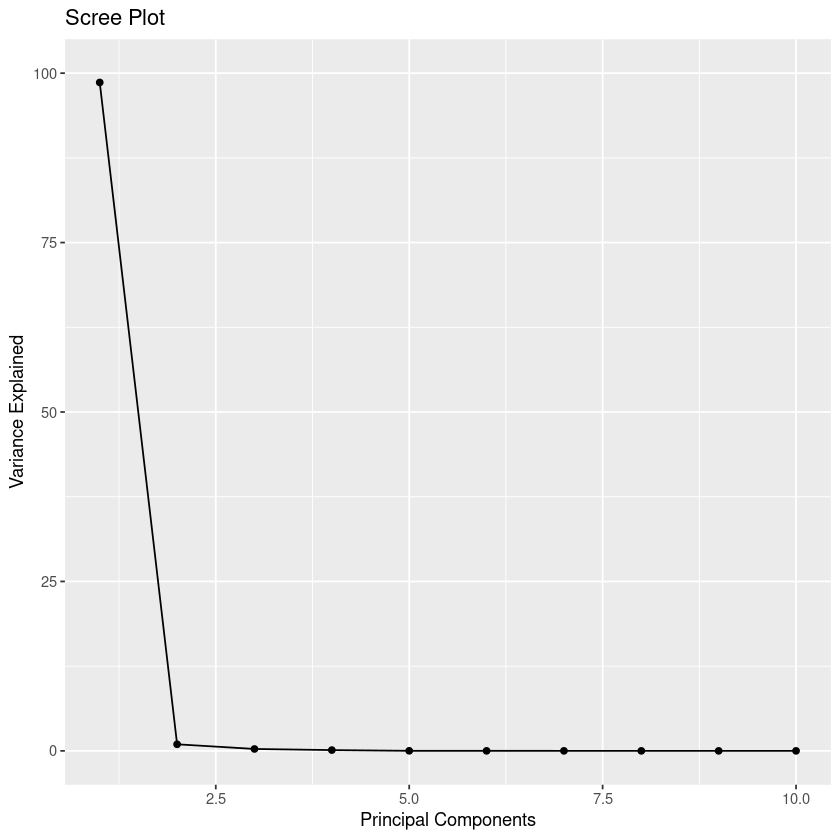

In [260]:
#creating the scree plot

qplot(c(1:10), percentVariance[1:10]) + 
  geom_line() + 
  xlab("Principal Components") + 
  ylab("Variance Explained") +
  ggtitle("Scree Plot") +
  ylim(0, 100)

## Solution 6.1.c)
Average RMSE value obtained is 11.64. All the codes are shown below.

Model Summary is shown in the output below

In [261]:
## The transformed values are stored in pcaObject as a sub-object called x:
pca_transformed <- as.data.frame(pcaObject$x[,1])
final_df1 <- cbind(pca_transformed,df_endpoints[,2])
colnames(final_df1) <- c('pca_pred1', 'fat_percent')
head(final_df1)

,pca_pred1,fat_percent
,<dbl>,<dbl>
1,-4.3037092,22.5
2,0.9983474,40.1
3,-7.1414228,8.4
4,-1.8085746,5.9
5,0.9883138,25.5
6,5.5619676,42.7


In [262]:
# Splitting the data 
set.seed(1)
myIndex <- createDataPartition(final_df1$fat_percent, p=0.80, list=FALSE)
train_df1 <- final_df1[myIndex, ]
test_df1 <- final_df1[-myIndex,]

In [263]:
# Training the Model
ctrl <- trainControl(method = "cv", number = 3)
fat_pcr <- train( x = data.frame("pca_pred1" = train_df1$pca_pred1), y = train_df1$fat_percent, method = "lm",trControl = ctrl)


In [264]:
fat_pcr

Linear Regression 

174 samples
  1 predictor

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 116, 117, 115 
Resampling results:

  RMSE      Rsquared   MAE     
  11.63743  0.2069777  9.341749

Tuning parameter 'intercept' was held constant at a value of TRUE

## Solution 6.1.d)
The RMSE obtained on the test set is 11.21 which is lower than the average RMSE obtained for the training set which was 11.68


In [265]:
# Using the model to predict for the tet set.
lmPred1 <- predict(fat_pcr, data.frame("pca_pred1" = test_df1$pca_pred1))
lmValues1 <- data.frame(obs = test_df1[,2], pred = lmPred1)

In [266]:
defaultSummary(lmValues1)

RMSE   Rsquared        MAE 
11.2097381  0.2047565  9.3057303

# Question 6.2 
## Solution 6.2.a) Data has been loaded and shown as below.
There are two entity in the data that is permeability and fingerprints.permeability is the permeability values for each compound.fingerprints is  a matrix of binary fingerprint indicator variables.Initially there are 165 Samples and 1107 Predictors in the data.


In [267]:
data(permeability)

In [268]:
?permeability

permeability {AppliedPredictiveModeling},R Documentation
permeability,permeability values for each compound.
fingerprints,a matrix of binary fingerprint indicator variables.


In [269]:
dim(fingerprints)


[1]  165 1107

## Solution 6.2.b) 
Used the nearZeroVar function to find the predictors having near zero variance.There were a total of 719 such predictors and they were removed.Finally only 388 predictors are left for modeling.

In [270]:
# Identifying the near Zero Variance Predictors
nearZeroVarFin <- nearZeroVar(fingerprints)

In [271]:
# Removing the near Zero Variance Predictors
nonNearZeroVarFin <- fingerprints[,-nearZeroVarFin]

In [272]:
dim(nonNearZeroVarFin)

[1] 165 388

## Solution 6.2.c) 
Since, there are less no of samples than the predictors, we will go with the 3:1 ratio split for the training and the test set.We have also used centre and scale as preprocessing step.RMSE was used to select the no of latent variables and the optimal model using the smallest value. The final value used for the model was ncomp=7. The corresponding resampled value of R^2 is 0.5188980.

Model and preprocessing summary and the rmse vs component plot is shown in the output below.


In [273]:
#Split data into training and test sets
set.seed(500)
trainingRows <- createDataPartition(permeability,p = 0.75,list = FALSE)
trainFinger <- nonNearZeroVarFin[trainingRows,]
trainPerm <- permeability[trainingRows,]
testFinger <- nonNearZeroVarFin[-trainingRows,]
testPerm <- permeability[-trainingRows,]


In [274]:
# Training the model
set.seed(100)
ctrl <- trainControl(method = "cv", number = 3)
plsTune <- train(trainFinger, trainPerm, method = "pls", tuneLength = 20, 
                 trControl = ctrl, preProc = c("center", "scale"))

In [275]:
summary(plsTune)

Data: 	X dimension: 125 388 
	Y dimension: 125 1
Fit method: oscorespls
Number of components considered: 7
TRAINING: % variance explained
          1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X           19.96    33.95    40.77    45.45    51.80    58.61    61.95
.outcome    37.36    54.82    61.03    67.58    72.53    76.03    78.55


In [276]:
plsTune


Partial Least Squares 

125 samples
388 predictors

Pre-processing: centered (388), scaled (388) 
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 84, 84, 82 
Resampling results across tuning parameters:

  ncomp  RMSE      Rsquared   MAE     
   1     12.60647  0.3377909  9.394137
   2     11.26207  0.4763384  8.026332
   3     11.49501  0.4707433  8.402907
   4     11.87878  0.4491230  8.586368
   5     11.36235  0.4960197  8.077987
   6     11.37745  0.4983823  8.122179
   7     11.20168  0.5188980  8.241472
   8     11.42316  0.5064072  8.397520
   9     11.45016  0.5105954  8.367529
  10     11.84775  0.4969139  8.663724
  11     12.54005  0.4648369  9.128646
  12     12.59825  0.4696736  9.097528
  13     12.63679  0.4741513  9.189824
  14     12.96040  0.4606710  9.269253
  15     13.02104  0.4652123  9.419108
  16     13.10632  0.4633559  9.498571
  17     13.04990  0.4710668  9.529615
  18     13.20326  0.4711241  9.801342
  19     13.30065  0.4714402  9.872639
 

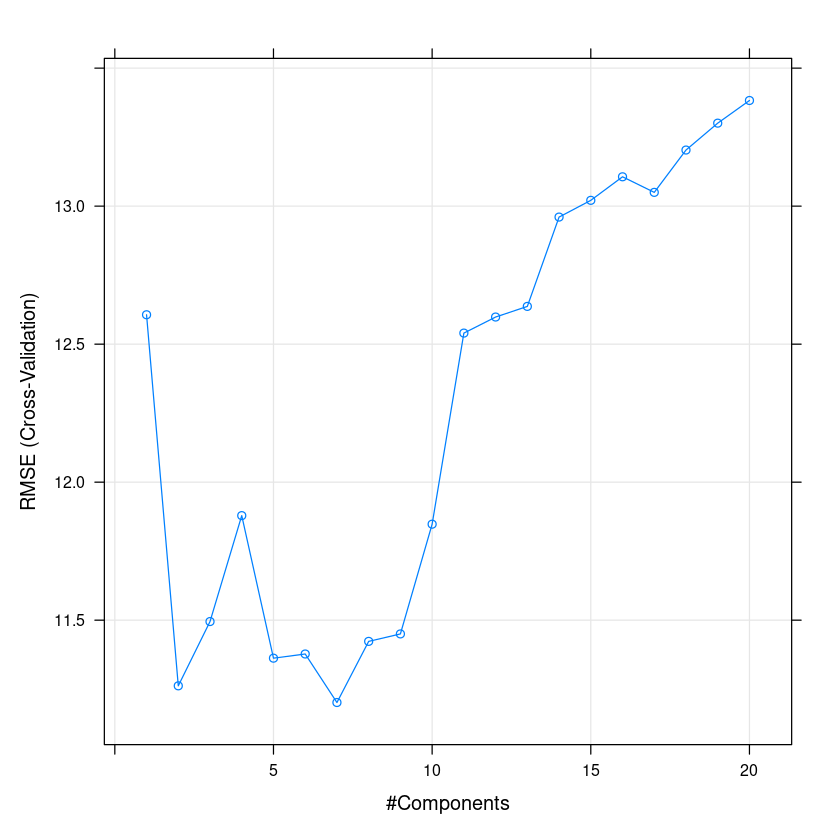

In [277]:
plot(plsTune,)

## Solution 6.2.d) 

Test set estimate of R^2 obtained is 0.43

In [278]:
set.seed(1)
pcr_predict <- predict(plsTune, testFinger)

In [279]:
plsValues1 <- data.frame(obs = testPerm, pred = pcr_predict)
defaultSummary(plsValues1)

RMSE   Rsquared        MAE 
12.7917005  0.4325831 10.3478226

# Question 6.3
## Solution 6.3.a)
Data has been loaded with the command shown below

In [280]:
data(ChemicalManufacturingProcess)

In [281]:
?ChemicalManufacturingProcess

ChemicalManufacturingProcess {AppliedPredictiveModeling},R Documentation


In [282]:
str(ChemicalManufacturingProcess)

'data.frame':	176 obs. of  58 variables:
 $ Yield                 : num  38 42.4 42 41.4 42.5 ...
 $ BiologicalMaterial01  : num  6.25 8.01 8.01 8.01 7.47 6.12 7.48 6.94 6.94 6.94 ...
 $ BiologicalMaterial02  : num  49.6 61 61 61 63.3 ...
 $ BiologicalMaterial03  : num  57 67.5 67.5 67.5 72.2 ...
 $ BiologicalMaterial04  : num  12.7 14.7 14.7 14.7 14 ...
 $ BiologicalMaterial05  : num  19.5 19.4 19.4 19.4 17.9 ...
 $ BiologicalMaterial06  : num  43.7 53.1 53.1 53.1 54.7 ...
 $ BiologicalMaterial07  : num  100 100 100 100 100 100 100 100 100 100 ...
 $ BiologicalMaterial08  : num  16.7 19 19 19 18.2 ...
 $ BiologicalMaterial09  : num  11.4 12.6 12.6 12.6 12.8 ...
 $ BiologicalMaterial10  : num  3.46 3.46 3.46 3.46 3.05 3.78 3.04 3.85 3.85 3.85 ...
 $ BiologicalMaterial11  : num  138 154 154 154 148 ...
 $ BiologicalMaterial12  : num  18.8 21.1 21.1 21.1 21.1 ...
 $ ManufacturingProcess01: num  NA 0 0 0 10.7 12 11.5 12 12 12 ...
 $ ManufacturingProcess02: num  NA 0 0 0 0 0 0 0 0 0 ...
 $

## Solution 6.3.b)
First I found the percentage of missing values column wise, since in each of the column the missing values is less than 10 percent, we do not need to drop any columns. Also, the total missing data in the dataframe is 1.034 percent, which is less than 5 percent, hence we can impute them. I have used the KNN imputation to impute the values.

In [324]:
# check for the missing values 
colSums(is.na(ChemicalManufacturingProcess))

Yield   BiologicalMaterial01   BiologicalMaterial02 
                     0                      0                      0 
  BiologicalMaterial03   BiologicalMaterial04   BiologicalMaterial05 
                     0                      0                      0 
  BiologicalMaterial06   BiologicalMaterial07   BiologicalMaterial08 
                     0                      0                      0 
  BiologicalMaterial09   BiologicalMaterial10   BiologicalMaterial11 
                     0                      0                      0 
  BiologicalMaterial12 ManufacturingProcess01 ManufacturingProcess02 
                     0                      0                      0 
ManufacturingProcess03 ManufacturingProcess04 ManufacturingProcess05 
                     0                      0                      0 
ManufacturingProcess06 ManufacturingProcess07 ManufacturingProcess08 
                     0                      0                      0 
ManufacturingProcess09 ManufacturingProcess10 ManufacturingProcess11 
                     0                      0                      0 
ManufacturingProcess12 ManufacturingProcess13 ManufacturingProcess14 
                     0                      0                      0 
ManufacturingProcess15 ManufacturingProcess16 ManufacturingProcess17 
                     0                      0                      0 
ManufacturingProcess18 ManufacturingProcess19 ManufacturingProcess20 
                     0                      0                      0 
ManufacturingProcess21 ManufacturingProcess22 ManufacturingProcess23 
                     0                      0                      0 
ManufacturingProcess24 ManufacturingProcess25 ManufacturingProcess26 
                     0                      0                      0 
ManufacturingProcess27 ManufacturingProcess28 ManufacturingProcess29 
                     0                      0                      0 
ManufacturingProcess30 ManufacturingProcess31 ManufacturingProcess32 
                     0                      0                      0 
ManufacturingProcess33 ManufacturingProcess34 ManufacturingProcess35 
                     0                      0                      0 
ManufacturingProcess36 ManufacturingProcess37 ManufacturingProcess38 
                     0                      0                      0 
ManufacturingProcess39 ManufacturingProcess40 ManufacturingProcess41 
                     0                      0                      0 
ManufacturingProcess42 ManufacturingProcess43 ManufacturingProcess44 
                     0                      0                      0 
ManufacturingProcess45 
                     0

In [284]:
# Finding the percentage of missing values in each column
(colMeans(is.na(ChemicalManufacturingProcess)))*100

Yield   BiologicalMaterial01   BiologicalMaterial02 
             0.0000000              0.0000000              0.0000000 
  BiologicalMaterial03   BiologicalMaterial04   BiologicalMaterial05 
             0.0000000              0.0000000              0.0000000 
  BiologicalMaterial06   BiologicalMaterial07   BiologicalMaterial08 
             0.0000000              0.0000000              0.0000000 
  BiologicalMaterial09   BiologicalMaterial10   BiologicalMaterial11 
             0.0000000              0.0000000              0.0000000 
  BiologicalMaterial12 ManufacturingProcess01 ManufacturingProcess02 
             0.0000000              0.5681818              1.7045455 
ManufacturingProcess03 ManufacturingProcess04 ManufacturingProcess05 
             8.5227273              0.5681818              0.5681818 
ManufacturingProcess06 ManufacturingProcess07 ManufacturingProcess08 
             1.1363636              0.5681818              0.5681818 
ManufacturingProcess09 ManufacturingProcess10 ManufacturingProcess11 
             0.0000000              5.1136364              5.6818182 
ManufacturingProcess12 ManufacturingProcess13 ManufacturingProcess14 
             0.5681818              0.0000000              0.5681818 
ManufacturingProcess15 ManufacturingProcess16 ManufacturingProcess17 
             0.0000000              0.0000000              0.0000000 
ManufacturingProcess18 ManufacturingProcess19 ManufacturingProcess20 
             0.0000000              0.0000000              0.0000000 
ManufacturingProcess21 ManufacturingProcess22 ManufacturingProcess23 
             0.0000000              0.5681818              0.5681818 
ManufacturingProcess24 ManufacturingProcess25 ManufacturingProcess26 
             0.5681818              2.8409091              2.8409091 
ManufacturingProcess27 ManufacturingProcess28 ManufacturingProcess29 
             2.8409091              2.8409091              2.8409091 
ManufacturingProcess30 ManufacturingProcess31 ManufacturingProcess32 
             2.8409091              2.8409091              0.0000000 
ManufacturingProcess33 ManufacturingProcess34 ManufacturingProcess35 
             2.8409091              2.8409091              2.8409091 
ManufacturingProcess36 ManufacturingProcess37 ManufacturingProcess38 
             2.8409091              0.0000000              0.0000000 
ManufacturingProcess39 ManufacturingProcess40 ManufacturingProcess41 
             0.0000000              0.5681818              0.5681818 
ManufacturingProcess42 ManufacturingProcess43 ManufacturingProcess44 
             0.0000000              0.0000000              0.0000000 
ManufacturingProcess45 
             0.0000000

In [285]:
# Finding the percentage of missing values in the whole dataframe.
(sum(is.na(ChemicalManufacturingProcess))/prod(dim(ChemicalManufacturingProcess)))*100

[1] 1.038401

In [286]:
Im <- preProcess(ChemicalManufacturingProcess,method="knnImpute") ## need {caret} package
# Apply inputation
ChemicalManufacturingProcess <- predict(Im,ChemicalManufacturingProcess)

In [287]:
# Verifying the percentage of missing values post imputation
(sum(is.na(ChemicalManufacturingProcess))/prod(dim(ChemicalManufacturingProcess)))*100

[1] 0

## Solution 6.3.c)
Applied the preprocessing of NearZeroVariance and also looked for the highly correlated predictors.Only 46 predictors are left in the dataset after considering for nearZeroVariance and highly correlated predictors.Also other preprocessing techniques such as boxcox, centre and scale has been applied inside the train function for each model based on the requirement.

Summary for each model is shown indivdually below and also a table has been shown with the average RMSE, best tuning parameter and R^2 for both training and the testing set below.

All the model preprocessing and summaries are shown below in the outputs.


Summary Table is shown below

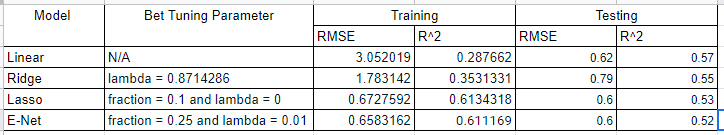

In [322]:
library("IRdisplay")
display_png(file="modelSummary.PNG") 


## Solution 6.3.d)
Code for predicting the output for each model has been shown in the below cells.
The testing RMSE is better(less) than the average RMSE obtained while training the model. However this indiviual value is almost similar for all the models when the RMSEs are compared after running the prediction on both the testing and the training data.Testing RMSE obtained for each model is shown in the table below.

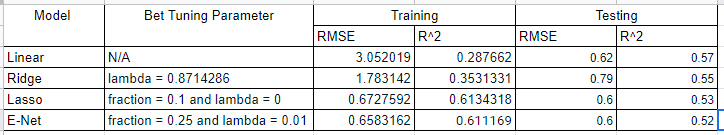

In [323]:
display_png(file="modelSummary.PNG") 

## Solution 6.3.e)

Linear Model has the best predictive ability since it has the highest R^2 obtained and also the RMSE of this model is similar in comparison to all other models.

I would choose the linear model for this scenario.

Note - I have trained the simple linear model since it is mentioned in the question, I have not trained the PCR or PLS and they could have provided the better result, given the no of predictors we have in the data.

## Solution 6.3.f)

Based on the best model, top 15 most important predictors are shown in the graph below.



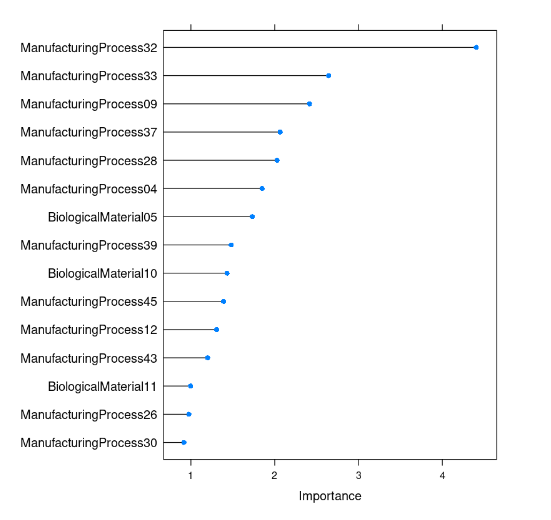

In [290]:
display_png(file="veryImp.png")

In [291]:
set.seed(10)
train_Rows <- caret::createDataPartition(ChemicalManufacturingProcess$Yield, p = 0.8, list = FALSE)

In [292]:
# Split data into training and test sets
set.seed(10)
# train_Rows <- createDataPartition(yield, p = 0.8, list = FALSE)

train_Predictors <- ChemicalManufacturingProcess[,2:58][train_Rows,]
train_Yield <- ChemicalManufacturingProcess$Yield[train_Rows]

test_Predictors <- ChemicalManufacturingProcess[,2:58][-train_Rows,]
test_Yield <- ChemicalManufacturingProcess$Yield[-train_Rows]

In [293]:
# Handling NearZeroVariance Predictors
nzvp <- nearZeroVar(train_Predictors)
pp_train_Predictors <- train_Predictors[-nzvp]
pp_test_Predictors <- test_Predictors[-nzvp]

In [294]:
# Handling highly correlated predictors
corrhigh = cor(pp_train_Predictors)
corrhighpp <- findCorrelation(corrhigh)
pp_train_Predictors <- pp_train_Predictors[, -corrhighpp]
pp_test_Predictors <- pp_test_Predictors[, -corrhighpp]

In [295]:
dim(pp_train_Predictors)

[1] 144  46

## Linear Model Training

In [296]:
# creating the model 
# lm model 
set.seed(78)
ctrl <- trainControl(method = "cv", number = 3)
chem_lm <- train(pp_train_Predictors , train_Yield, method = "lm",trControl = ctrl, preProc = c("BoxCox","center", "scale"))


Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”


## Linear Model and Preprocessing Summary

In [297]:
chem_lm

Linear Regression 

144 samples
 46 predictor

Pre-processing: centered (46), scaled (46) 
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 96, 96, 96 
Resampling results:

  RMSE      Rsquared  MAE     
  3.052019  0.287662  1.102525

Tuning parameter 'intercept' was held constant at a value of TRUE

## Linear Model Prediction

In [298]:
# Using the  linear model to predict for the tet set.
clm_pred_test <- predict(chem_lm, pp_test_Predictors)
chemLmValues_test <- data.frame(obs =test_Yield , pred = clm_pred_test)
defaultSummary(chemLmValues_test)

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”


RMSE  Rsquared       MAE 
0.6201681 0.5720407 0.5031000

In [299]:
# Using the  linear model to predict for the training set.
clm_pred_train <- predict(chem_lm, pp_train_Predictors)
chemLmValues_train <- data.frame(obs =train_Yield , pred = clm_pred_train)
defaultSummary(chemLmValues_train)

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”


RMSE  Rsquared       MAE 
0.4770846 0.7817770 0.3735790

## Ridge Model Training

In [300]:
ridgeGrid <- data.frame(.lambda = seq(0.1, 1, length = 15))
set.seed(10000)
chem_ridgeReg <- train(pp_train_Predictors , train_Yield, method = "ridge", 
                     tuneGrid = ridgeGrid, trControl = ctrl,
                     preProc = c("center", "scale"))

## Ridge Model Summary and Preprocessing Summary 

In [301]:
chem_ridgeReg

Ridge Regression 

144 samples
 46 predictor

Pre-processing: centered (46), scaled (46) 
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 96, 96, 96 
Resampling results across tuning parameters:

  lambda     RMSE      Rsquared   MAE      
  0.1000000  2.967132  0.2035824  0.9288468
  0.1642857  2.495956  0.2505862  0.8595737
  0.2285714  2.246722  0.2790966  0.8240293
  0.2928571  2.094744  0.2978837  0.8058349
  0.3571429  1.994615  0.3111046  0.7988016
  0.4214286  1.925677  0.3209028  0.7976450
  0.4857143  1.877111  0.3284723  0.7997871
  0.5500000  1.842666  0.3345213  0.8045059
  0.6142857  1.818456  0.3394917  0.8106859
  0.6785714  1.801925  0.3436712  0.8180930
  0.7428571  1.791311  0.3472543  0.8266755
  0.8071429  1.785359  0.3503761  0.8363032
  0.8714286  1.783142  0.3531331  0.8473161
  0.9357143  1.783960  0.3555960  0.8587456
  1.0000000  1.787274  0.3578175  0.8705692

RMSE was used to select the optimal model using the smallest value.
The final value 

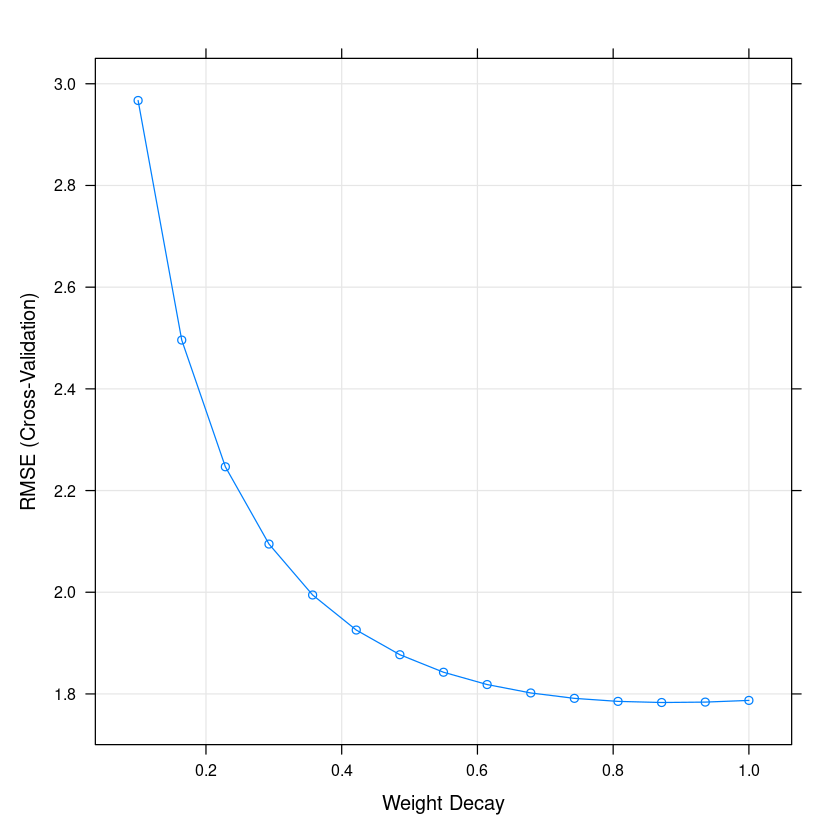

In [302]:
plot(chem_ridgeReg)

## Ridge Model Prediction

In [303]:
# Using the  Ridge Regression model to predict for the test set.
crrm_pred_test <- predict(chem_ridgeReg, pp_test_Predictors)
chemRrmValues_test <- data.frame(obs =test_Yield , pred = crrm_pred_test)
defaultSummary(chemRrmValues_test)

RMSE  Rsquared       MAE 
0.7922517 0.5493646 0.6508064

In [304]:
# Using the  Ridge Regression model to predict for the training set.
crrm_pred_train <- predict(chem_ridgeReg, pp_train_Predictors)
chemRrmValues_train <- data.frame(obs =train_Yield , pred = crrm_pred_train)
defaultSummary(chemRrmValues_train)

RMSE  Rsquared       MAE 
0.7121787 0.6954938 0.5763174

## Lasso Model Training

In [305]:
enetGrid <- expand.grid(.lambda = c(0), .fraction = seq(.01, 0.2, length = 20))
set.seed(10000)
chem_LassoReg <- train(pp_train_Predictors , train_Yield,preProc = c("center", "scale"), method = "enet", 
                     tuneGrid = enetGrid, trControl = ctrl,na.action=na.omit
                     )

## Lasso Model and Preprocessing Summary

In [306]:
chem_LassoReg

Elasticnet 

144 samples
 46 predictor

Pre-processing: centered (46), scaled (46) 
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 96, 96, 96 
Resampling results across tuning parameters:

  fraction  RMSE       Rsquared   MAE      
  0.01      0.9656352  0.4328769  0.7714624
  0.02      0.9181164  0.4928290  0.7306285
  0.03      0.8723369  0.5406635  0.6921373
  0.04      0.8282641  0.5783957  0.6584771
  0.05      0.7891612  0.5971978  0.6283987
  0.06      0.7561044  0.6052927  0.6014758
  0.07      0.7289733  0.6086040  0.5778632
  0.08      0.7058756  0.6102492  0.5594280
  0.09      0.6873212  0.6105531  0.5453883
  0.10      0.6727592  0.6134318  0.5355604
  0.11      0.7148918  0.5553984  0.5483583
  0.12      0.8266147  0.4879849  0.5645762
  0.13      0.9629144  0.4507022  0.5805673
  0.14      1.1021974  0.4302951  0.5986515
  0.15      1.2316311  0.4199093  0.6169796
  0.16      1.3218532  0.4176040  0.6260391
  0.17      1.4224482  0.4143622  0.6382171
  0

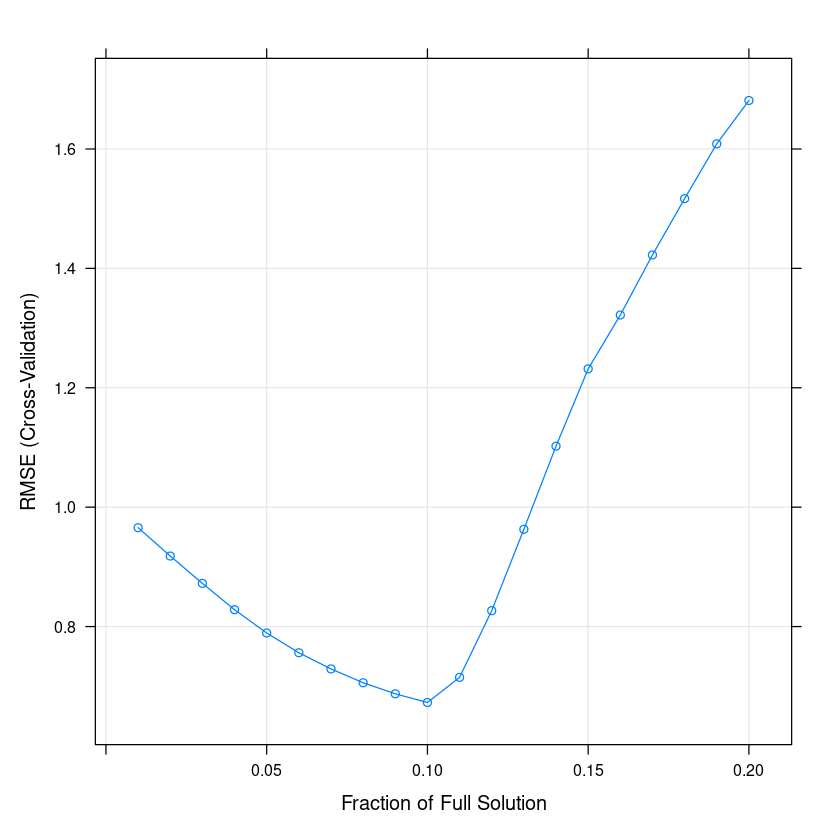

In [307]:
plot(chem_LassoReg)

## Lasso Model Prediction

In [308]:
# Using the  Lasso Regression model to predict for the test set.
clrm_pred_test <- predict(chem_LassoReg, pp_test_Predictors)
chemLrmValues_test <- data.frame(obs =test_Yield , pred = clrm_pred_test)
defaultSummary(chemLrmValues_test)

RMSE  Rsquared       MAE 
0.6030314 0.5329951 0.5088003

In [309]:
# Using the  Lasso Regression model to predict for the training set.
clrm_pred_train <- predict(chem_LassoReg, pp_train_Predictors)
chemLrmValues_train <- data.frame(obs =train_Yield , pred = clrm_pred_train)
defaultSummary(chemLrmValues_train)

RMSE  Rsquared       MAE 
0.5763864 0.6943425 0.4574213

## E-NET Model Training

In [310]:
enetGrid <- expand.grid(.lambda = c(0, 0.01, .1), .fraction = seq(.05, 1, length = 20))
set.seed(100)
enetTune <- train(pp_train_Predictors , train_Yield,preProc = c("center", "scale"), method = "enet", 
                  tuneGrid = enetGrid, trControl = ctrl)

## E-NET Model and Preprocessing Summary

In [319]:
enetTune

Elasticnet 

144 samples
 46 predictor

Pre-processing: centered (46), scaled (46) 
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 96, 96, 96 
Resampling results across tuning parameters:

  lambda  fraction  RMSE       Rsquared   MAE      
  0.00    0.05      0.8271346  0.5728582  0.6522272
  0.00    0.10      0.6903915  0.6218823  0.5405116
  0.00    0.15      0.6641033  0.6121632  0.5226077
  0.00    0.20      0.6659102  0.5947596  0.5232034
  0.00    0.25      0.8006594  0.5009309  0.5622392
  0.00    0.30      0.9020928  0.4564873  0.5914491
  0.00    0.35      0.9689868  0.4379530  0.6199157
  0.00    0.40      1.1915471  0.3599816  0.6951447
  0.00    0.45      1.5764940  0.2812597  0.7872426
  0.00    0.50      1.7641305  0.2501896  0.8371122
  0.00    0.55      1.9496995  0.2303324  0.8783174
  0.00    0.60      2.1588253  0.2157298  0.9174082
  0.00    0.65      2.3809127  0.2034623  0.9572919
  0.00    0.70      2.6609201  0.1898682  1.0160246
  0.00    0.75 

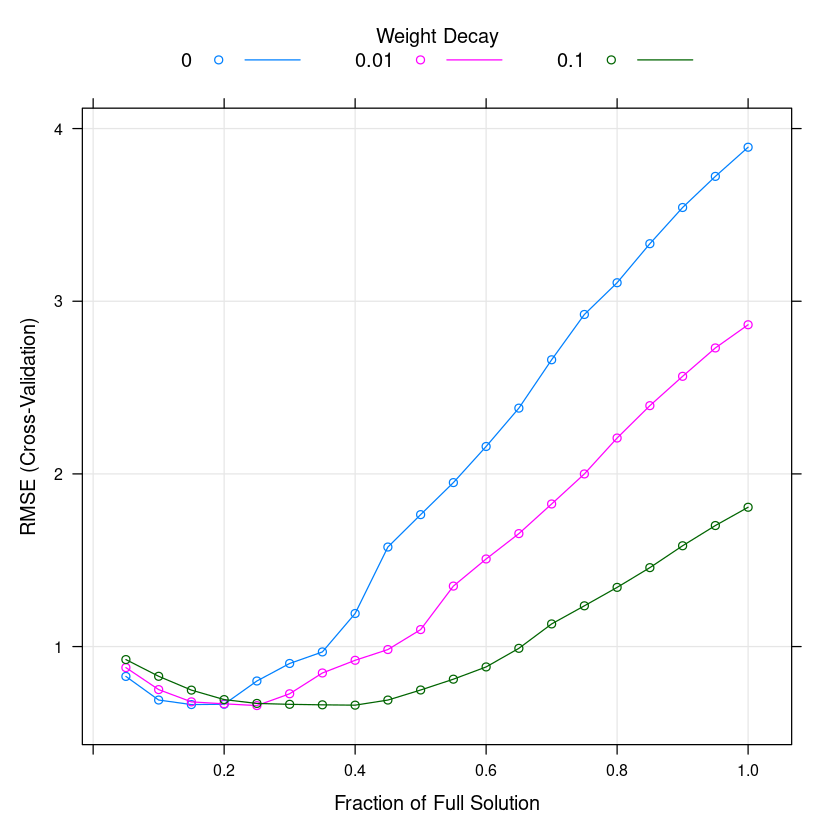

In [312]:
plot(enetTune)

## E-NET Model Prediction

In [320]:
# Using the  ENET  model to predict for the test set.
enetTune_test <- predict(enetTune, pp_test_Predictors)
enetTuneValues_test <- data.frame(obs =test_Yield , pred = enetTune_test)
defaultSummary(enetTuneValues_test)

RMSE  Rsquared       MAE 
0.6075793 0.5286312 0.5156693

In [314]:
# Using the  Ridge Regression model to predict for the training set.
enetTune_test <- predict(enetTune, pp_train_Predictors)
enetTuneValues_test <- data.frame(obs =train_Yield , pred = enetTune_test)
defaultSummary(enetTuneValues_test)

RMSE  Rsquared       MAE 
0.5867795 0.6856521 0.4636730

## Finding the most important predictors

In [315]:
lmImp <- varImp(chem_lm, scale = FALSE)

In [316]:
lmImp

lm variable importance

  only 20 most important variables shown (out of 45)

                       Overall
ManufacturingProcess32  4.4042
ManufacturingProcess33  2.6425
ManufacturingProcess09  2.4145
ManufacturingProcess37  2.0643
ManufacturingProcess28  2.0275
ManufacturingProcess04  1.8495
BiologicalMaterial05    1.7321
ManufacturingProcess39  1.4804
BiologicalMaterial10    1.4308
ManufacturingProcess45  1.3898
ManufacturingProcess12  1.3074
ManufacturingProcess43  1.1994
BiologicalMaterial11    0.9967
ManufacturingProcess26  0.9758
ManufacturingProcess30  0.9163
ManufacturingProcess07  0.9054
BiologicalMaterial01    0.8883
ManufacturingProcess38  0.7222
ManufacturingProcess15  0.6941
ManufacturingProcess03  0.6864

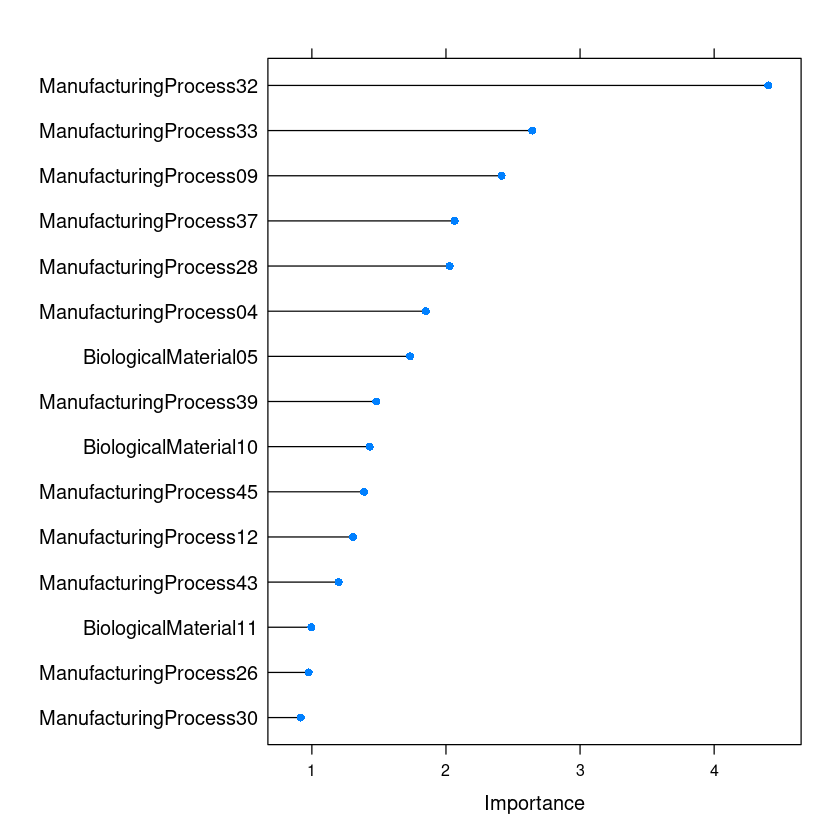

In [317]:
plot(lmImp, top=15, scales = list(y = list(cex = 1)))